# HDF5 + mongoDB

This databases uses `pymongo` as the backend database. Only meta data (or part of it) is stored in the database, not the raw data. To understand how dataset raw data is linked to the database see the respective chapter in this document.

In [1]:
import pymongo
from pymongo import MongoClient

from h5rdmtoolbox import tutorial
import h5rdmtoolbox as h5tbx

import numpy as np
from pprint import pprint

h5tbx.use(None)

h5tbx.__version__

'0.9.0a0'

## First things first: Connection to the DB:
Connect to the mongod client:

In [2]:
client = MongoClient()
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

Create a database and a (test) collection named "digits":

In [3]:
db = client['h5database_notebook_tutorial']
collection = db['digits']

# drop all content in order to start from scratch:
collection.drop()

## Testdata
We will take test data from scikit-learn, namely the hand-written digits ((https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html):

In [4]:
from sklearn.datasets import load_digits  # ! pip install scikit-learn
digits = load_digits()

Fill a HDF5 file with the loaded data. We additionally compute the mean count and two gray occurance properties (dissimilarity and correlation). Those three datasets together with the true digit of the image are linked to the image via HDF dimension scales:

In [5]:
from skimage.feature import graycomatrix, graycoprops

filename = h5tbx.utils.generate_temporary_filename()

with h5tbx.File(filename, 'w') as h5:
    ds_trg = h5.create_dataset('digit',
                               data=digits.target,
                               make_scale=True)
    ds_img = h5.create_dataset('images',
                               shape=(len(digits.images), 8, 8))
    
    ds_mean = h5.create_dataset('mean',
                                shape=(len(digits.images), ),
                                make_scale=True)
    ds_diss = h5.create_dataset('dissimilarity',
                                shape=(len(digits.images), ),
                                make_scale=True)
    ds_corr = h5.create_dataset('correlation',
                                shape=(len(digits.images), ),
                                make_scale=True)
    
    
    for i, img in enumerate(digits.images):
        ds_img[i, :, :] = img
        ds_mean[i] = np.mean(img)
        
        glcm = graycomatrix(img.astype(int), distances=[5], angles=[0], levels=256,
                            symmetric=True, normed=True)
        ds_diss[i] = graycoprops(glcm, 'dissimilarity')[0, 0]
        ds_corr[i] = graycoprops(glcm, 'correlation')[0, 0]
        
    ds_img.dims[0].attach_scale(ds_trg)
    ds_img.dims[0].attach_scale(ds_mean)
    ds_img.dims[0].attach_scale(ds_diss)
    ds_img.dims[0].attach_scale(ds_corr)
    h5.dump()

## Filling the database

To insert data from the HDF5 file into the DB, we need the accessor "mongo":

In [6]:
from h5rdmtoolbox.database import mongo

In [7]:
with h5tbx.File(filename) as h5:
    h5['images'].mongo.insert(0, collection, update=False)

Count the number of collections inserted:

In [8]:
collection.count_documents({})

1797

### Find one:

In [9]:
one_res = collection.find_one({'digit': {'$eq': 3}})
one_res

{'_id': ObjectId('65095de3f7968b0058b637c4'),
 'filename': 'C:\\Users\\da4323\\AppData\\Local\\h5rdmtoolbox\\h5rdmtoolbox\\tmp\\tmp_5\\tmp0',
 'name': '/images',
 'basename': 'images',
 'file_creation_time': datetime.datetime(2023, 9, 19, 8, 37, 51, 126000),
 'shape': [1797, 8, 8],
 'ndim': 3,
 'hdfobj': 'dataset',
 'slice': [[3, 4, 1], [0, None, 1], [0, None, 1]],
 'digit': 3,
 'mean': 4.171875,
 'dissimilarity': 4.875,
 'correlation': -0.3547935485839844}

We found one entry only because we asked for one only. Note, that the sult dictionary provides a "slice" entry. This is the slice within the 3D array in the HDF file. We can use this to slice the array. There is even a method in the accessor to simplify this:

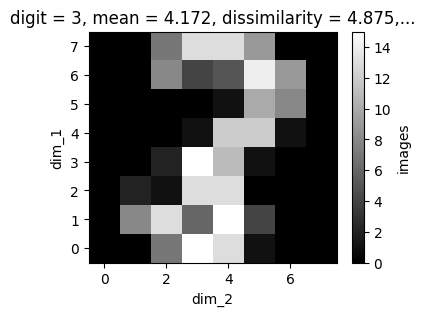

In [10]:
import matplotlib.pyplot as plt

with h5tbx.File(filename) as h5:
    plt.figure(figsize=(4,3))
    h5.images.mongo.slice(one_res['slice']).plot(cmap='gray')

## Find many:

Let' query a rang of data. Mean count shall be above 5 counts and the digit is >3 and <=8:

In [11]:
collection.count_documents({'mean': {'$gt': 5}, 'digit': {'$gt': 3}, 'digit': {'$lte': 8}})
many_res = collection.find({'mean': {'$gt': 5}, 'digit': {'$gt': 3}, 'digit': {'$lte': 8}})

Inspect the result by the help of pandas:

In [12]:
import pandas as pd

,name,basename,file_creation_time,shape,ndim,hdfobj,digit,mean,dissimilarity,correlation
0,/images,images,2023-09-19 08:37:51.126,"[1797, 8, 8]",3,dataset,2,5.375000,6.291667,-0.360439
1,/images,images,2023-09-19 08:37:51.126,"[1797, 8, 8]",3,dataset,5,5.343750,7.250000,-0.430473
2,/images,images,2023-09-19 08:37:51.126,"[1797, 8, 8]",3,dataset,8,5.578125,7.416667,-0.469501
3,/images,images,2023-09-19 08:37:51.126,"[1797, 8, 8]",3,dataset,0,5.031250,7.875000,-0.520575
4,/images,images,2023-09-19 08:37:51.126,"[1797, 8, 8]",3,dataset,3,5.015625,6.375000,-0.383382


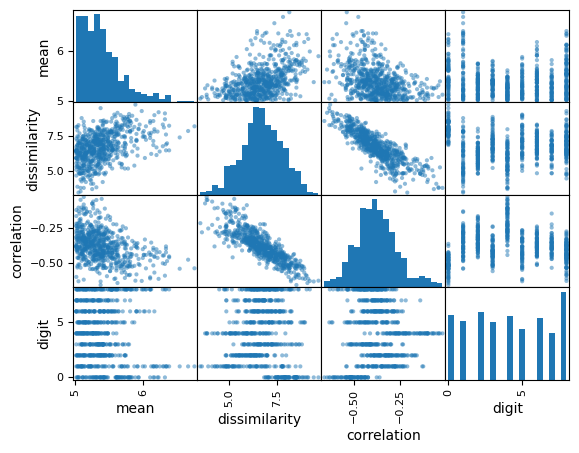

In [13]:
df = pd.DataFrame(data=[r for r in many_res.rewind()])
df.drop('_id', inplace=True, axis=1)
df.drop('filename', inplace=True, axis=1)
df.drop('slice', inplace=True, axis=1)

pd.plotting.scatter_matrix(df[['mean', 'dissimilarity', 'correlation', 'digit']], hist_kwds={'bins': 20})
df.head()

## Query for other meta data.

First of all we could have insert the full file. We might have decided to insert only a group content or really all data in the file, thus a recursive run that insert all data. Ok, let's do that:

In [14]:
db = client['h5database_notebook_tutorial']
collection_full_digits = db['full_digits']

# drop all content in order to start from scratch:
collection_full_digits.drop()

In [15]:
with h5tbx.File(filename) as h5:
    h5.mongo.insert(collection_full_digits, recursive=True)

The first entry looks like this:

In [16]:
collection_full_digits.find_one({})

{'_id': ObjectId('65095de4bf7512e9120c1303'),
 '__h5rdmtoolbox_version__': '0.9.0a0',
 'basename': '',
 'file_creation_time': datetime.datetime(2023, 9, 19, 8, 37, 51, 126000),
 'filename': 'C:\\Users\\da4323\\AppData\\Local\\h5rdmtoolbox\\h5rdmtoolbox\\tmp\\tmp_5\\tmp0',
 'hdfobj': 'group',
 'name': '/'}

It is the data of the root group. It shows all attribute of the group.